In [1]:
%load_ext autoreload
%autoreload 2
from sklearn.utils import shuffle
from utils import *
from topic_modeling import *
from download_edgar import *
import matplotlib.pyplot as plt
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel

In [2]:
def plot_difference(mdiff, title="", annotation=None):
    """Helper function to plot difference between models.

    Uses matplotlib as the backend."""
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(18, 14))
    data = ax.imshow(mdiff, cmap='RdBu_r', origin='upper')
    plt.title(title)
    plt.colorbar(data)

In [3]:
# Get the training documents from 1 year:
corpus = query_intersection(2013, 2018, 'Energy & Transportation', 'Power & Energy', False)
docs = corpus[-1]

In [4]:
# Covert documents to tokens, bag of word and dictionary format:
texts, bows, dic, bigrams = tokens_bows_dict(docs, 1, 0.5, 3, 100, True)

In [5]:
# Get train and test set:
texts_train, texts_test, bows_train, bows_test = train_test_split(texts, bows)

In [6]:
start = 40
end = 70 + 1
step = 5

In [7]:
# Build models for comparison:
models, coherences, perplexities = models_codherence_perplexity(\
        texts_train, texts_test, bows_train, bows_test, dic,    \
        topic_start=start, topic_end=end, step=step, chunk=50, passes=2)

Building model of 40 topics
Building model of 45 topics
Building model of 50 topics
Building model of 55 topics
Building model of 60 topics
Building model of 65 topics
Building model of 70 topics


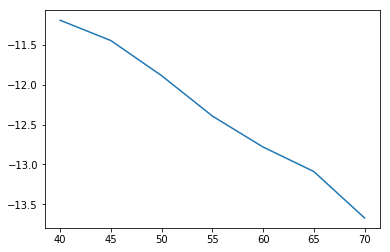

In [8]:
# Plot perplexity vs number of topics:
plt.plot(range(start, end, step), perplexities)

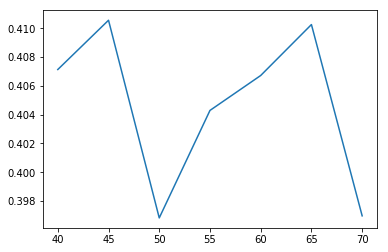

In [9]:
# Plot coherence vs number of topics:
plt.plot(range(start, end, step), coherences)

In [92]:
chosen = models[-1]

In [93]:
topic_list = chosen.show_topics(chosen.num_topics, 10)
top_topics = chosen.top_topics(texts=texts_train, coherence='c_v', topn=10)

In [95]:
topic_list

[(0,
  '0.002*"conclus" + 0.002*"convert" + 0.002*"admiss" + 0.002*"aforement" + 0.002*"chief" + 0.002*"complic" + 0.002*"western" + 0.002*"disput" + 0.002*"deliveri" + 0.002*"tighten"'),
 (1,
  '0.002*"conclus" + 0.002*"convert" + 0.002*"admiss" + 0.002*"aforement" + 0.002*"chief" + 0.002*"complic" + 0.002*"western" + 0.002*"disput" + 0.002*"deliveri" + 0.002*"tighten"'),
 (2,
  '0.024*"these" + 0.021*"under" + 0.014*"there" + 0.012*"thi" + 0.010*"with" + 0.009*"such" + 0.008*"howev" + 0.007*"while" + 0.007*"therefor" + 0.007*"below"'),
 (3,
  '0.002*"conclus" + 0.002*"convert" + 0.002*"admiss" + 0.002*"aforement" + 0.002*"chief" + 0.002*"complic" + 0.002*"western" + 0.002*"disput" + 0.002*"deliveri" + 0.002*"tighten"'),
 (4,
  '0.064*"these" + 0.047*"under" + 0.047*"thi" + 0.033*"there" + 0.021*"while" + 0.020*"below" + 0.018*"less" + 0.016*"with" + 0.015*"howev" + 0.013*"when"'),
 (5,
  '0.002*"conclus" + 0.002*"convert" + 0.002*"admiss" + 0.002*"aforement" + 0.002*"chief" + 0.002*"

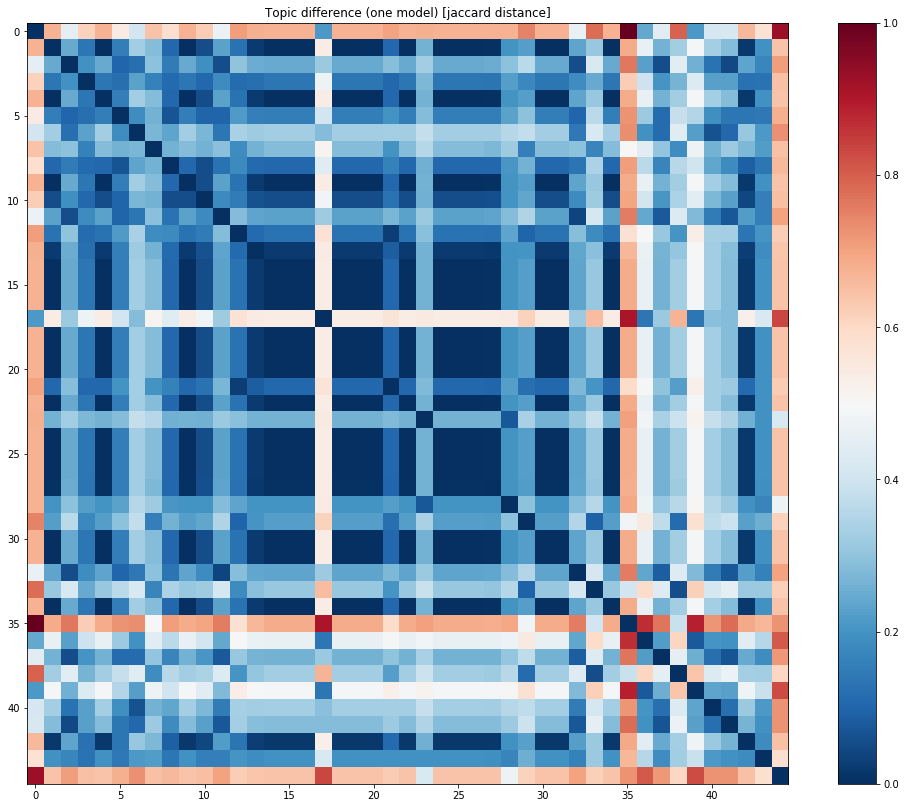

In [84]:
mdiff, annotation = chosen.diff(chosen, distance='hellinger', num_words=50)
plot_difference(mdiff, title="Topic difference (one model) [jaccard distance]", annotation=annotation)

In [55]:
union = topic_union(top_topics, topic_list, mdiff, 10)

In [18]:
bows_vs_years = get_bows_vs_years(corpus, dic, bigrams)

In [56]:
hists = topic_hist_years(bows_vs_years, chosen, 0.1, union, mdiff)

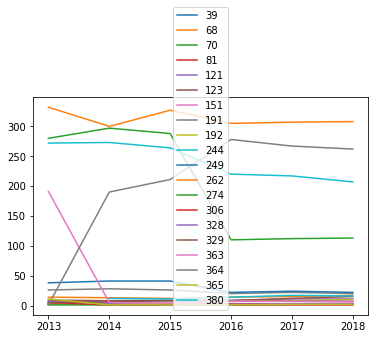

In [59]:
hists = [sorted(hist, key=lambda t: t[0]) for hist in hists]
topic_id = sorted(union)
cac = [[p[1] for p in hist] for hist in hists]
df = pd.DataFrame(cac, columns=topic_id, index=range(2013, 2019))

df.plot()
#df.drop(columns=[72, 244, 123, 144, 24]).plot()

In [58]:
topics = dict(topic_list)
topics = {k: re.findall(r'[a-z_]+', v) for (k, v) in topics.items()}
[print((i, topics[i])) for i in union]

(39, ['penn', 'pennsylvania', 'postretir', 'corp', 'surviv', 'nonaccret', 'legaci', 'bhca', 'forma', 'boli'])
(68, ['gift', 'patent', 'atm', 'currenc', 'mobil_phone', 'solut', 'foreign_currenc', 'germani', 'processor', 'distributor'])
(70, ['puerto_rico', 'florida', 'firstbank', 'storm', 'virgin_island', 'hurrican', 'bulk', 'hurrican_irma', 'doral', 'fhlbni'])
(81, ['park', 'township', 'jersey', 'volcker', 'philadelphia', 'junior_subordin', 'newark', 'gloucest', 'sbhc', 'vision'])
(121, ['virginia', 'bankshar', 'richmond', 'north_carolina', 'lock', 'acquire', 'bedford', 'intrus', 'preliminari', 'novo'])
(123, ['puerto_rico', 'orient', 'firstbank', 'storm', 'auto', 'hurrican', 'florida', 'doral', 'gnma', 'bulk'])
(151, ['energi', 'warehous', 'texa', 'esop', 'dalla', 'score', 'metropolitan', 'distress', 'transport', 'enhanc_prudenti'])
(191, ['fhlbank', 'fhfa', 'mandatorili_redeem', 'gse', 'convent', 'pentegra', 'master', 'privat_label', 'nonmemb', 'embed'])
(192, ['energi', 'phoenix', '

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [ ]:
bows_vs_years = get_bows_vs_years(corpus, dic, bigrams)
chosen_model = models[-1]
res = []
for year in bows_vs_years:
    distribution = chosen_model.get_document_topics(year, 0.0)
    res.append([dis[1] for dis in distribution])
df = pd.DataFrame(res).T.rename(columns={0:2013, 1:2014, 2:2015, 3:2016, 4:2017, 5:2018})
df = df.T.fillna(method='pad').fillna(method='bfill').T